<a href="https://colab.research.google.com/github/Gabxist/I.C./blob/main/c%C3%B3digo_para_juntar_dados.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from pandas import read_csv, to_datetime
import os
import numpy as np
from scipy.stats import pearsonr
import matplotlib.pyplot as plt
from astropy.timeseries import LombScargle
from scipy.stats import levene
from statsmodels.formula.api import ols
from statsmodels.stats.diagnostic import het_breuschpagan
import seaborn as sns
"https://github.com/cgpilapanta/timeseries/blob/main/TEG_Cap_01.ipynb"
# Definir nomes de cada coluna

cabec = ['DATE','TIME', 'DECIMAL DATE', 'MJD', 'U',]
caminho = '/content/I.C./'
cabec2 = ['DATE','TIME','DECIMAL DATE','RAIN','U']

In [ ]:
# Importar repósitorio de GitHub
!rm -r I.C
!git clone https://github.com/Gabxist/I.C..git


In [ ]:
# Importar arquivo de texto (dataframe Pandas)
Dados_amz = read_csv(caminho +'dados_rio_amazonas.CSV', names = cabec2,sep=r';')
Gps = read_csv(caminho + 'Gps_NAUS.txt', names = cabec, sep=r"\s+")
Ntol = read_csv(caminho + "NTOL_NAUS.txt", names = cabec, sep=r'\s+')
Grace = read_csv(caminho +"GRACE_NAUS.txt", names = cabec, sep=r'\s+')
Hydl = read_csv(caminho + "HYDL_NAUS.txt", names = cabec, sep=r'\s+')
Ntal = read_csv(caminho + "NTAL_NAUS.txt", names = cabec, sep=r'\s+')
Slel = read_csv(caminho + "SLEL_NAUS.txt", names = cabec, sep=r'\s+')

In [ ]:
#retirando dos dados a média:

def retirar_media (nome):
  """
  Calcula a média utilizando numpy.mean
  Retira de cada dado a média
  """
  media = np.mean(nome['U'])
  nome['U'] = nome['U']-media
  return nome

# Função para identificar o maximo e o mínimo,

def min_max(nome):
  '''
  imprime o máximo, o mínimo e o desvio apdrão
  '''
  a = np.max(nome['U'])
  b = np.min(nome['U'])
  print(f'o MAX é {a}')
  print(f'o mímino é {b}')
  desvio_pdr = np.std(nome['U'])
  print(f'o desvio padrão é {desvio_pdr},')

#função para comparar duas colunas, e calclular o coeficiente de correlação:

def corr_pears (dado):
  '''
  Imprime o coeficiente de correlação entre os dados
  '''
  print(f'o coeficiente de correlação é de {pearsonr(dado["U"], dado["U RIO"],)} para gps e ntol')


In [ ]:
#Funções para mudar os dados:

def renon_Mud_ord (nome):
  '''
  Altera as duas colunas de data e hora em uma só para facilitar o tratamento dos dados.
  Re-organiza o df para a ordem em que a coluna com data e hora fica no início e exclui as colunas de data e hora
  '''
  nome['datetime'] = nome['DATE']+" "+nome["TIME"]
  nome['datetime'] = to_datetime(nome['datetime'],format="%d/%m/%Y %H:%M:%S")
  df = nome.reindex(["datetime","DATE","TIME","DECIMAL DATE","MJD","U"],axis=1)
  return df

def mudar_dados (nome):
  '''
  Altera as duas colunas de data e hora em uma só para facilitar o tratamento dos dados.
  Re-organiza o df para a ordem em que a coluna com data e hora fica no início e exclui
  todas as colunas exceto a de dados importantes, nesse caso  somente a coluna "U"
  '''
  nome['datetime'] = nome['DATE']+" "+nome["TIME"]
  nome['datetime'] = to_datetime(nome['datetime'],format="%d/%m/%Y %H:%M:%S")
  df = nome.reindex(["datetime","DECIMAL DATE","MJD","U","DATE","TIME"],axis=1)
  df = df.drop(columns=["DATE","TIME","DECIMAL DATE"])
  return df

In [ ]:
#função para fazer a Análise espectral por mínimos quadrados:

def calc_min_quad (nome):
  """
  Não entendi o que Faz
  """
  t_gau = range(1,len(nome)+1)
  frequencia, poder = LombScargle(t_gau, nome).autopower()
  plt.plot(frequencia, poder)
  plt.xlabel("Dias")
  plt.ylabel("Amplitude")
  plt.show()

In [ ]:
#Função para dividir os dados e usar função levene:

def plot_met(nome):
  """
  Divide o dataframe pela metade e plota cada metade com uma cor diferente
  retorna os intervalos dos dados (metade 1 e metade 2)
  """
  out =outliers(nome)
  metade = round(len(nome)/2)
  div1, div2 = nome["U"].to_numpy()[0:metade], nome["U"].to_numpy()[metade:]
  time1, time2 = nome["datetime"].to_numpy()[0:metade], nome["datetime"].to_numpy()[metade:]
  min, max = quartis(nome)
  plt.axhline(y=max, color='red', linestyle='--',label='Upper Threshold')
  plt.axhline(y=min, color='orange', linestyle='--',label='Lower Threshold')
  plt.plot(time1, div1, color = 'blue')
  plt.plot(time2, div2, color = 'green')
  plt.scatter(out['datetime'], out['U'], color='red', label = 'Outliers',marker='*')
  plt.title("Up component variation through time ")
  plt.ylabel("Up component")
  plt.xlabel("Year")
  plt.legend()
  plt.show()
  return(div1,div2)

def div_levene (nome):
  """
  utiliza a função plot_met e compara as duas metades
  """
  div1, div2 = plot_met(nome)
  print(f"primeira metade, variância = {div1.var()} média = {div1.mean()}")
  print(f"segunda metade, variância = {div2.var()} média = {div2.mean()}")
  if levene(div1, div2)[1] < 0.05:
    print('Reject the null hypothesis of equal variance between groups.')
    print(f'P-value is {levene(div1, div2)[1]}.')
  else:
    print('Fail to reject the null hypothesis of equal variance between groups.')
    print(f'P-value is {levene(div1, div2)[1]}.')

def quartis(nome):
  '''
  separa os dados em quartis e calcula uma tolerancia para os dados
  '''
  q1 = nome["U"].quantile(0.25)
  q3 = nome['U'].quantile(0.75)
  iqr = q3 - q1
  tol_min = q1 - 1.5 * iqr
  tol_max = q3 + 1.5 * iqr
  return tol_min, tol_max

In [ ]:
#Mostrar dados considerados outliers
def outliers (nome):
  tol_min, tol_max = quartis(nome)
  dados_outliers = nome[(nome['U'] < tol_min)|(nome['U'] > tol_max)]
  return dados_outliers

In [ ]:
#Histograma dos dados
def histograma(df, nome):
  plt.hist(df['U'], bins="auto")
  plt.title(f'{nome},')
  plt.show()

In [ ]:
def testeBP (nome):
  df_model = ols(formula='U~MJD', data=nome).fit()
  def modelo_teste (nome):
    s = []
    for i in nome:
      a = [1,i]
      s.append(a)
    return np.array(s)
  comp_model = modelo_teste(nome['U'])
  bp_test = het_breuschpagan(df_model.resid, comp_model)

  print ('LM-test p_value')
  print (bp_test[1],)


In [ ]:
def Trend (nome):
# Ajuste por mínimos quadrados da função polinomial de grau 1
  ajuste = np.polyfit(nome['MJD'], nome['U'], 1)

# Determinação da tendência
  trend = np.polyval(ajuste, nome['MJD'])

# Valores de tendência

  print('trend = %f' % (ajuste[0]))
  print('intercept = %f' % (ajuste[1]))

# Parâmetros de figura
  plt.figure(figsize=(12,6))

# Plotagem das coordenadas GPS
  plt.scatter(nome['datetime'], nome['U'], s=1)

# Plotagem da função polinomial de ajuste
  plt.plot(nome['datetime'], trend, 'r', linestyle='--')

# Parâmetros adicionais da figura
  plt.text(0.4, 0.925,'LS trend = ' + str(np.round(ajuste[0],4)) + 'mm/year', ha='right', transform=plt.gca().transAxes, color = 'k')
  plt.ylabel("UP mm")
  plt.xlabel("Ano")
  plt.title("trend over time")


In [ ]:
#utilizando as funções para pegar somente as informações que eu quero

Dados_amz_U = retirar_media(mudar_dados(Dados_amz))
Gps = retirar_media(renon_Mud_ord(Gps))
Ntol = retirar_media(mudar_dados(Ntol))
Grace = retirar_media(mudar_dados(Grace))
Hydl = retirar_media(mudar_dados(Hydl))
Ntal = retirar_media(mudar_dados(Ntal))
Slel = retirar_media(mudar_dados(Slel))

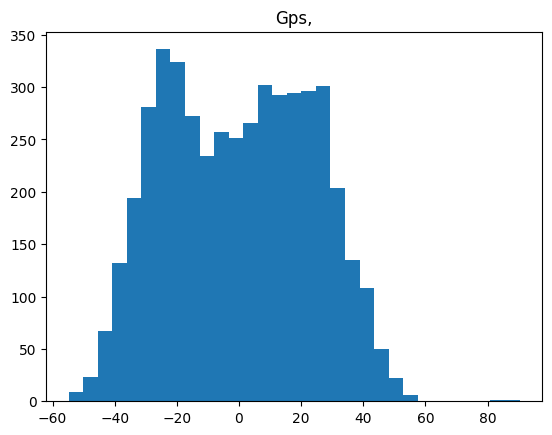

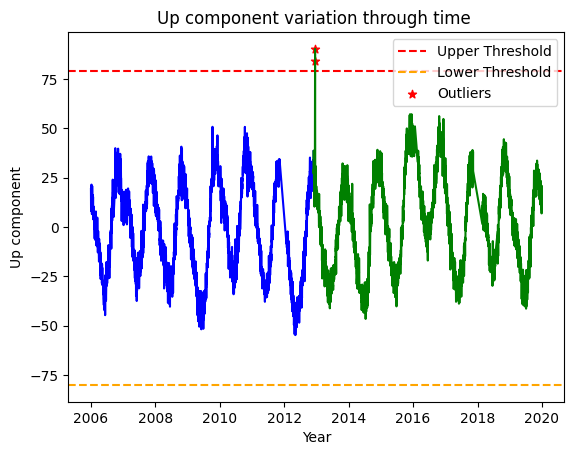

primeira metade, variância = 536.8409301561779 média = -2.2618425752425932
segunda metade, variância = 554.4144644999909 média = 2.261842575242594
Fail to reject the null hypothesis of equal variance between groups.
P-value is 0.8776691945923109.


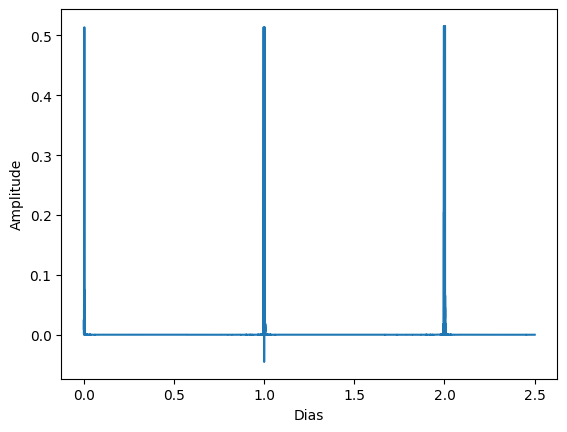

trend = 0.001301
intercept = -73.177292


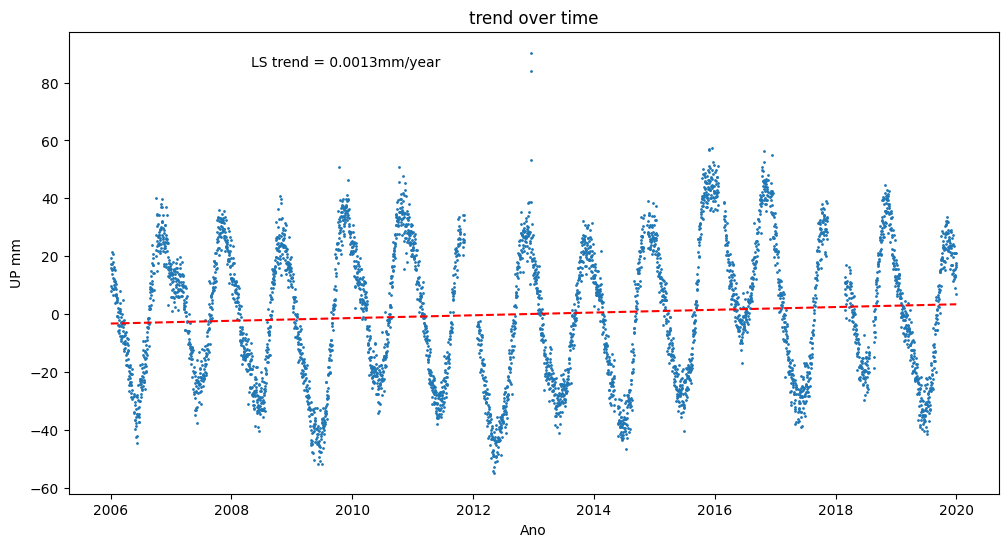

In [ ]:
#mostrar os dados GPS
histograma(Gps,'Gps')
div_levene(Gps)
calc_min_quad(Gps['U'])
Trend(Gps)

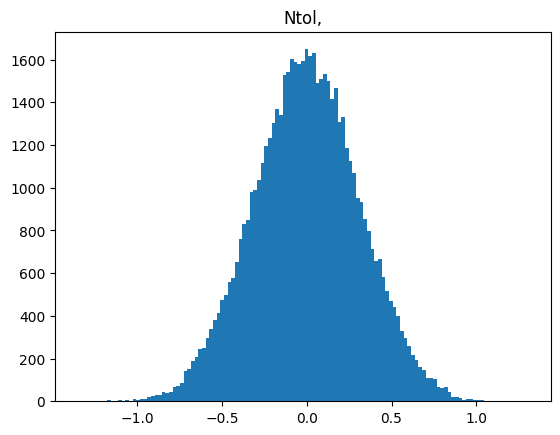

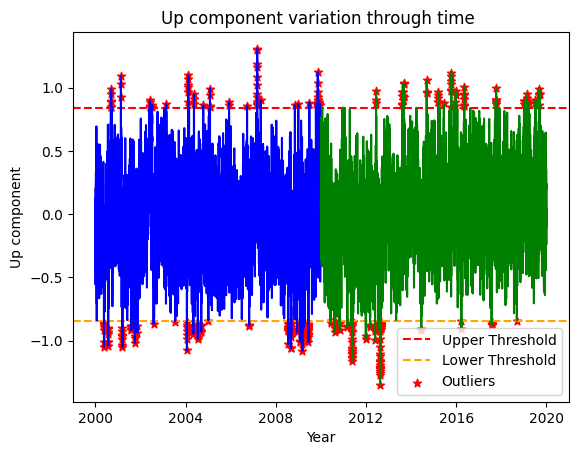

primeira metade, variância = 0.0932052374400953 média = -0.02432988623192064
segunda metade, variância = 0.10088725903746602 média = 0.024329053615438245
Reject the null hypothesis of equal variance between groups.
P-value is 9.608348244715283e-14.


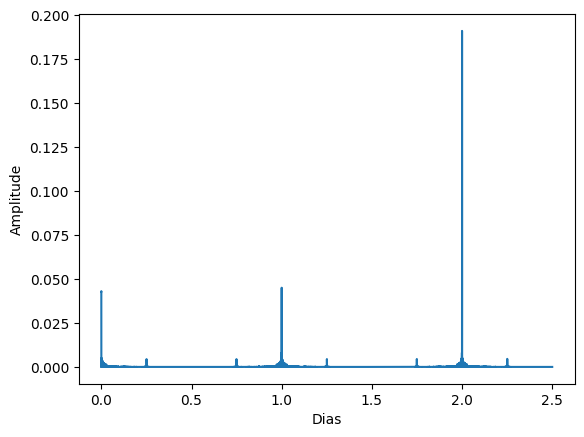

trend = 0.000021
intercept = -1.136120


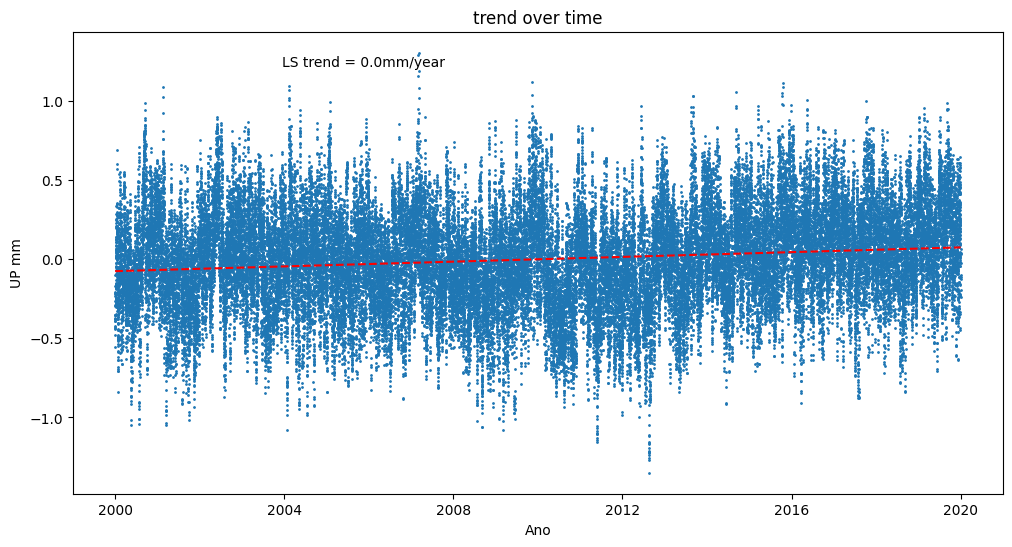

In [ ]:
#mostrar os dados Ntol
histograma(Ntol,"Ntol")
div_levene(Ntol)
calc_min_quad(Ntol['U'])
Trend(Ntol)

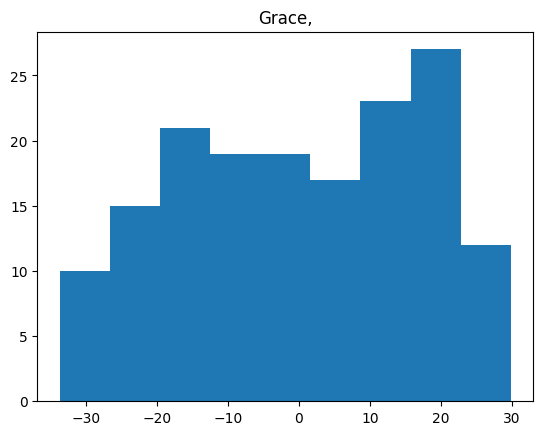

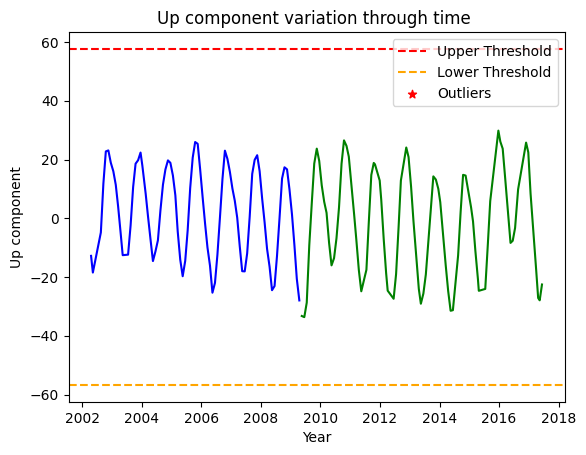

primeira metade, variância = 223.69128481656264 média = 2.1155918924562327
segunda metade, variância = 335.012327792317 média = -2.141710310881617
Reject the null hypothesis of equal variance between groups.
P-value is 0.025607559443481354.


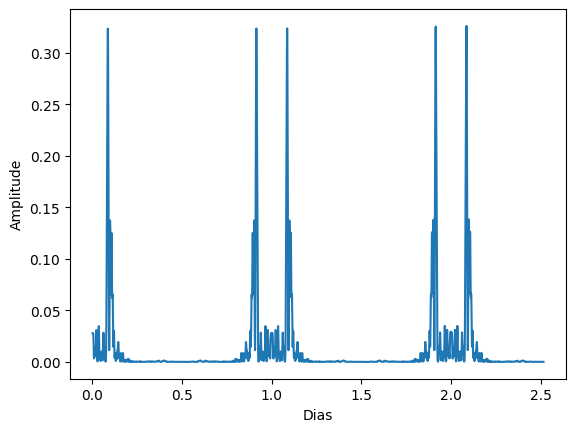

trend = -0.001674
intercept = 92.107511


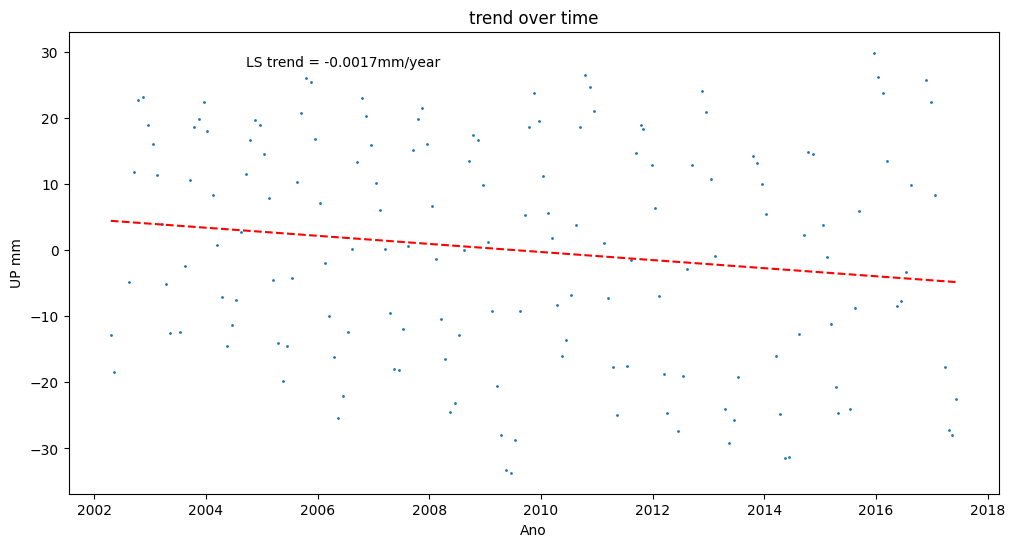

In [ ]:
#mostrar os dados Grace
histograma(Grace,"Grace")
div_levene(Grace)
calc_min_quad(Grace['U'])
Trend(Grace)

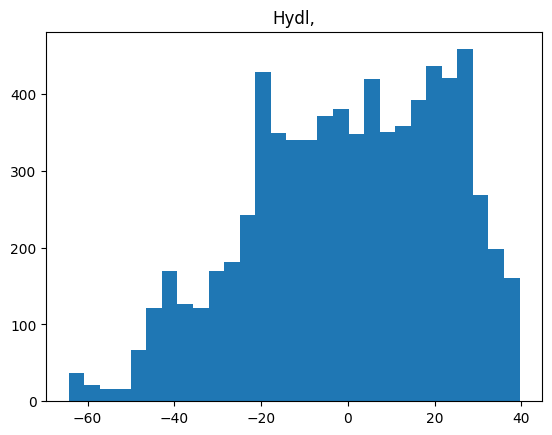

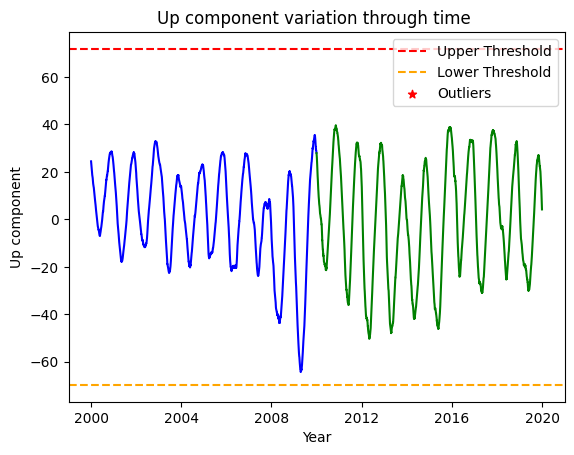

primeira metade, variância = 422.523114615597 média = 0.9375493589726733
segunda metade, variância = 595.7660206580298 média = -0.9372927070813567
Reject the null hypothesis of equal variance between groups.
P-value is 3.060294098435206e-56.


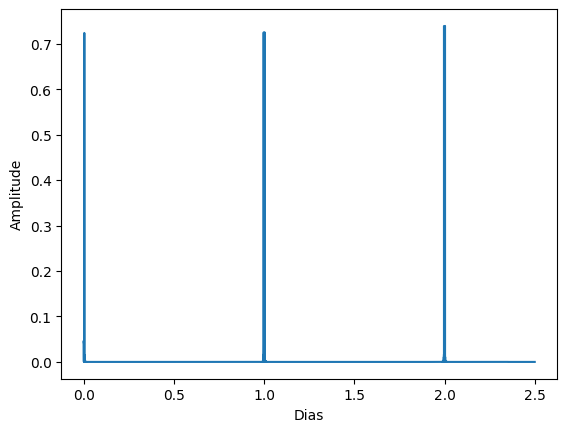

trend = -0.000970
intercept = 53.539177


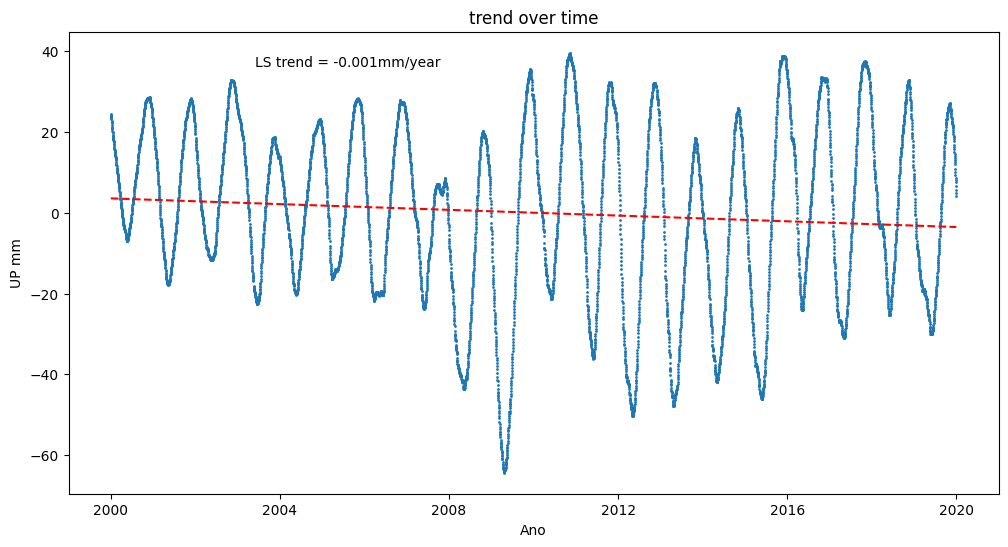

In [ ]:
#mostrar os dados Hydl
histograma(Hydl,"Hydl")
div_levene(Hydl)
calc_min_quad(Hydl['U'])
Trend(Hydl)

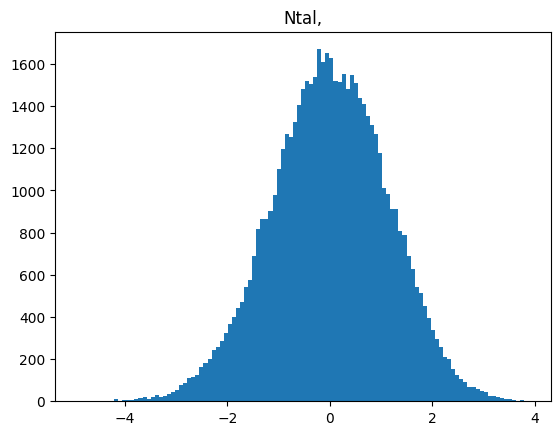

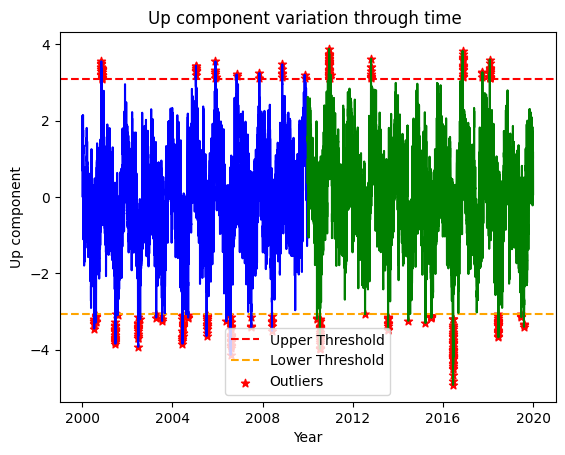

primeira metade, variância = 1.2615730823312215 média = -0.0453466241295855
segunda metade, variância = 1.313836032019459 média = 0.04534507227906267
Reject the null hypothesis of equal variance between groups.
P-value is 0.001260583108436004.


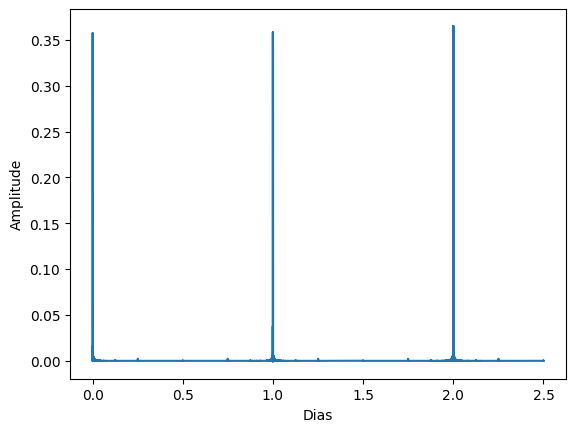

trend = 0.000021
intercept = -1.142989


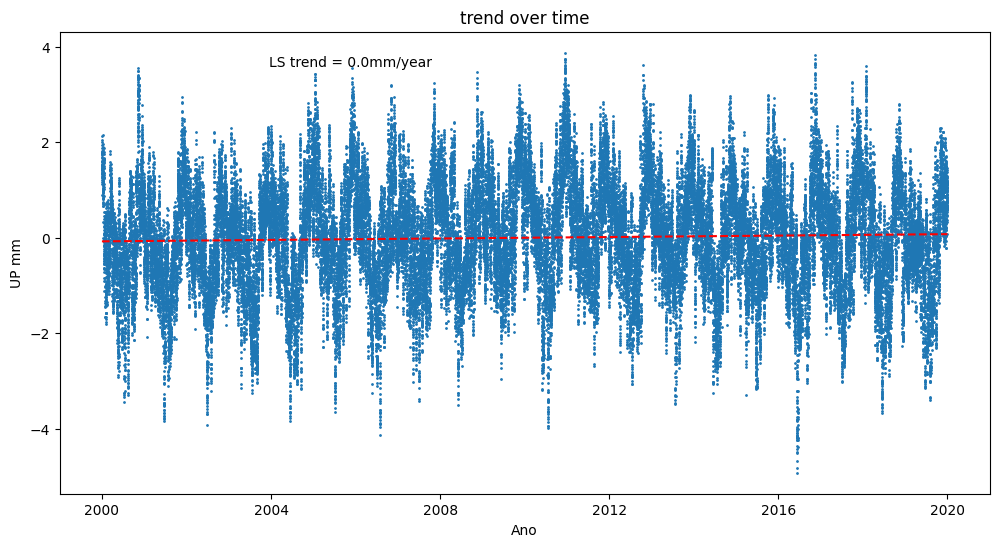

In [ ]:
#mostrar os dados Ntal
histograma(Ntal,"Ntal")
div_levene(Ntal)
calc_min_quad(Ntal['U'])
Trend(Ntal)

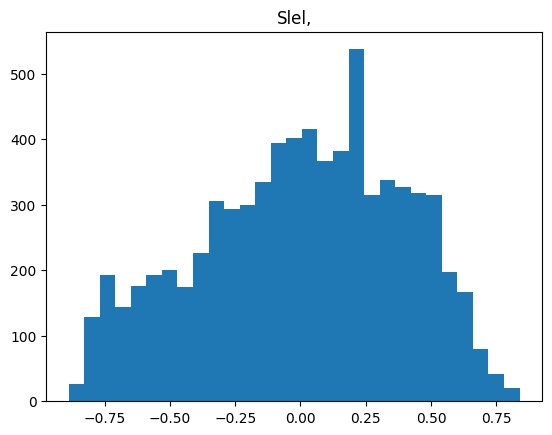

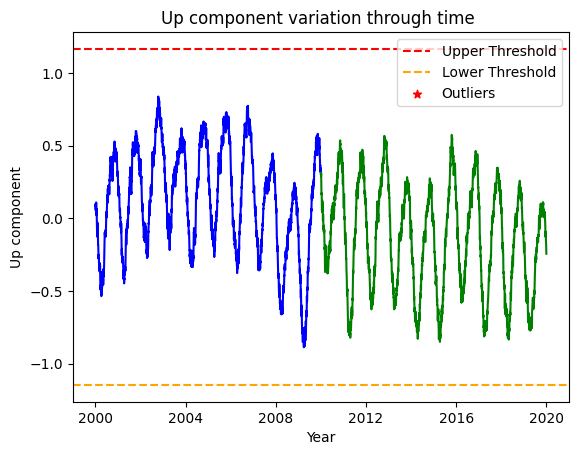

primeira metade, variância = 0.1306487720801925 média = 0.13645159272881782
segunda metade, variância = 0.13063013250447977 média = -0.13641423943214967
Fail to reject the null hypothesis of equal variance between groups.
P-value is 0.08270149229616484.


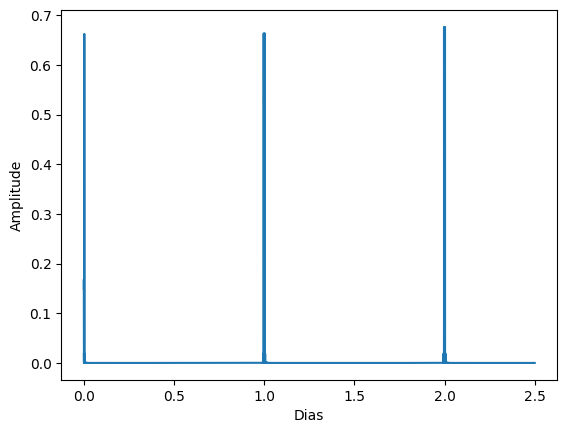

trend = -0.000070
intercept = 3.883705


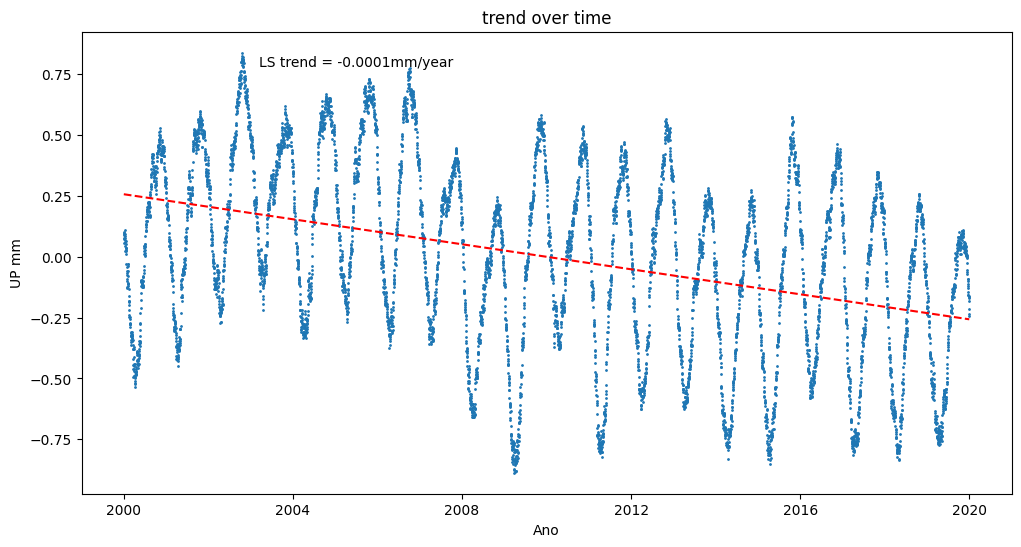

In [ ]:
#mostrar os dados Slel
histograma(Slel, "Slel")
div_levene(Slel)
calc_min_quad(Slel['U'])
Trend(Slel)

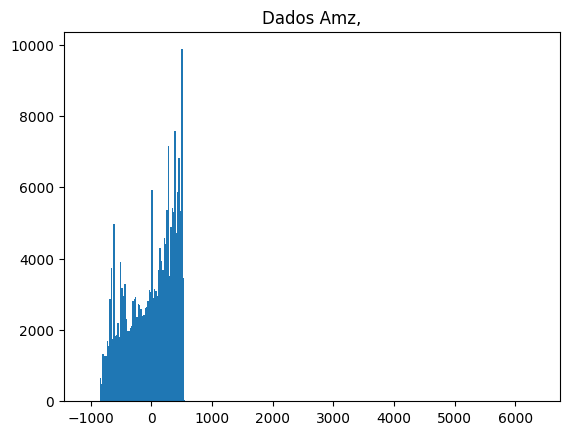

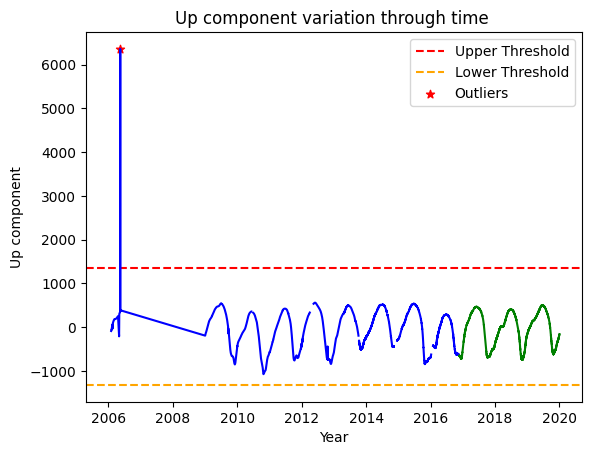

primeira metade, variância = nan média = nan
segunda metade, variância = nan média = nan
Fail to reject the null hypothesis of equal variance between groups.
P-value is nan.


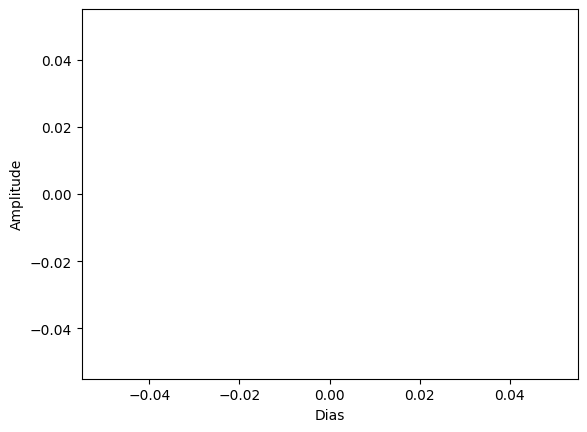

LinAlgError: SVD did not converge in Linear Least Squares

In [ ]:
#mostrar os dados Amazonas
histograma(Dados_amz_U,"Dados Amz")
div_levene(Dados_amz_U)
calc_min_quad(Dados_amz_U['U'])
Trend(Dados_amz_U)

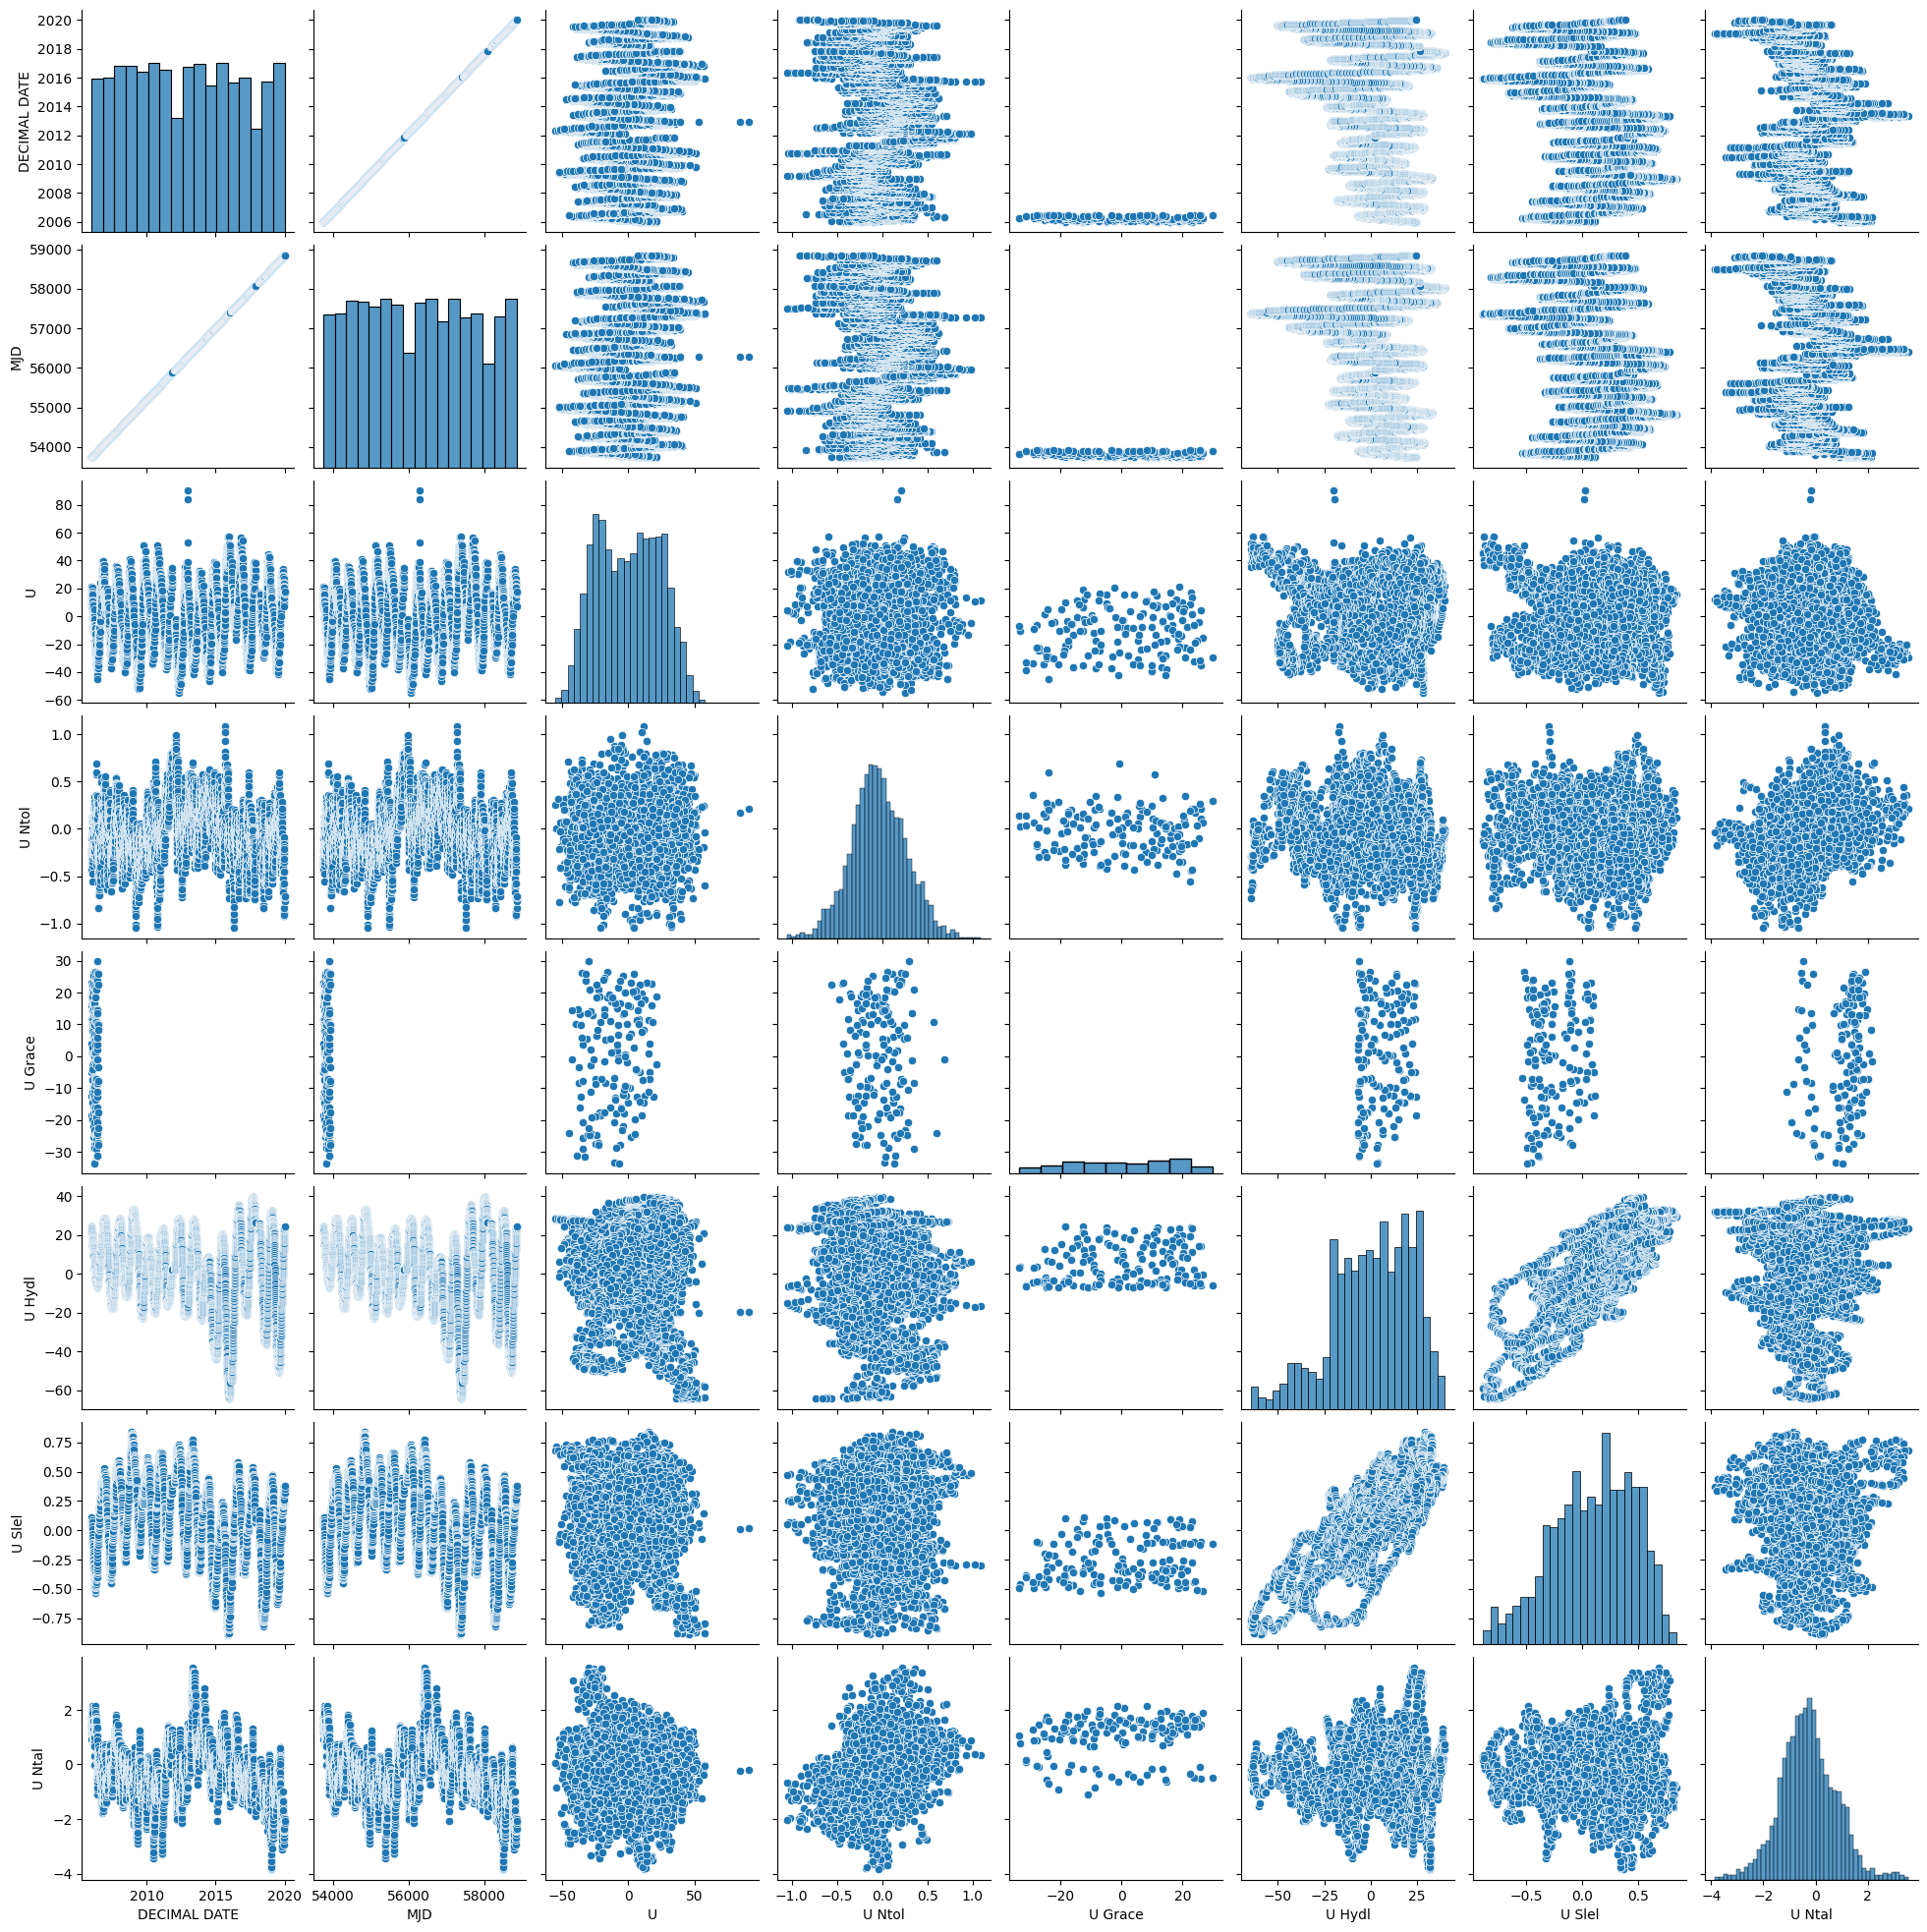

In [ ]:
juntos = []
juntos = Gps.join(Ntol["U"], rsuffix=" Ntol")
juntos = juntos.join(Grace["U"], rsuffix=" Grace")
juntos = juntos.join(Hydl["U"], rsuffix=" Hydl")
juntos = juntos.join(Slel["U"], rsuffix=" Slel")
juntos = juntos.join(Ntal["U"], rsuffix=" Ntal")
sns.pairplot(juntos)
plt.show()